In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import linregress

In [2]:
vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
vss_structures = vss_sse_df.index
functionals = vss_sse_df.columns

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_structures = csd_sse_df.index

csd_targets = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
vss_targets = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')

#format the dataframes differently to make working with them easier

vss_pbe_sse = vss_sse_df.drop([key for key in vss_sse_df.keys() if 'scan' in key], axis=1)
vss_scan_sse = vss_sse_df.drop([key for key in vss_sse_df.keys() if 'pbe' in key], axis=1)
csd_pbe_sse = csd_sse_df.drop([key for key in csd_sse_df.keys() if 'scan' in key], axis=1)
csd_scan_sse = csd_sse_df.drop([key for key in csd_sse_df.keys() if 'pbe' in key], axis=1)

scan_map = {}
pbe_map = {}
for column in vss_scan_sse.columns:
    scan_map[column] = int(column.split('_')[-1])
for column in vss_pbe_sse.columns:
    pbe_map[column] = int(column.split('_')[-1])

vss_scan_sse = vss_scan_sse.rename(columns=scan_map).sort_index(axis=1)
vss_pbe_sse = vss_pbe_sse.rename(columns=pbe_map).sort_index(axis=1)
csd_scan_sse = csd_scan_sse.rename(columns=scan_map).sort_index(axis=1)
csd_pbe_sse = csd_pbe_sse.rename(columns=pbe_map).sort_index(axis=1)

This notebook contains analyses on the behavior of VSSE vs. HFX curves in the VSS-452-HFX and CSD-76-HFX datasets.

# Monotonicity Assessment

In [3]:
def monotonic_decrease(x, num_different=0):
    dx = np.diff(x)
    if sum(dx <= 0) >= len(x)-1-num_different:
        #subtract an extra 1 since the differences will be one item shorter than the original list
        return True
    else:
        return False

def concave_up(x, y, num_different=0):
    dydx = np.gradient(y, x, edge_order=2)
    d2ydx2 = np.gradient(dydx, x, edge_order=2)
    if sum(d2ydx2 >= 0) >= len(x) - num_different:
        return True
    else:
        return False

def concave_down(x, y, num_different=0):
    dydx = np.gradient(y, x, edge_order=2)
    d2ydx2 = np.gradient(dydx, x, edge_order=2)
    if sum(d2ydx2 <= 0) >= len(x) - num_different:
        return True
    else:
        return False

functionals = ['pbe', 'scan']

for base_functional in functionals:
    print(f'For functional {base_functional.upper()}:')
    print('=====================')
    for jdx, dataset in enumerate(['csd', 'vss']):
        if dataset == 'csd':
            df = csd_sse_df
            target_df = csd_targets
        else:
            df = vss_sse_df
            target_df = vss_targets
        num_monotonic = 0
        num_up = 0
        num_down = 0
        total = 0
        for idx, row in df.iterrows():
            if np.isnan(target_df['hfx_' + base_functional][idx]):
                #do not count a structure if it is not in VSS-452-HFX or CSD-76-HFX
                continue
            else:
                total += 1
            keys = [int(key.split('_')[-1]) for key in row.keys() if not np.isnan(row[key]) and base_functional in key]
            values = [row[key] for key in row.keys() if not np.isnan(row[key]) and base_functional in key]
            keys, values = zip(*sorted(zip(keys, values)))
            if monotonic_decrease(values, num_different=0):
                num_monotonic += 1

            if len(keys) > 1 and concave_up(keys, values, num_different=0):
                num_up += 1

            if len(keys) > 1 and concave_down(keys, values, num_different=0):
                num_down += 1

        if jdx == 0:
            print('For CSD-76-HFX:')
        else:
            print('For VSS-452-HFX:')
        print(f'The number of monotonically decreasing structures is {num_monotonic} / {total}, corresponding to {num_monotonic/total*100:1.2f}%.')
        print(f'The number of concave up structures is {num_up} / {total}, corresponding to {num_up/total*100:1.2f}%.')
        print(f'The number of concave down structures is {num_down} / {total}, corresponding to {num_down/total*100:1.2f}%.')
    print('\n')

For functional PBE:
For CSD-76-HFX:
The number of monotonically decreasing structures is 69 / 69, corresponding to 100.00%.
The number of concave up structures is 33 / 69, corresponding to 47.83%.
The number of concave down structures is 0 / 69, corresponding to 0.00%.
For VSS-452-HFX:
The number of monotonically decreasing structures is 397 / 405, corresponding to 98.02%.
The number of concave up structures is 231 / 405, corresponding to 57.04%.
The number of concave down structures is 1 / 405, corresponding to 0.25%.


For functional SCAN:
For CSD-76-HFX:
The number of monotonically decreasing structures is 67 / 67, corresponding to 100.00%.
The number of concave up structures is 25 / 67, corresponding to 37.31%.
The number of concave down structures is 0 / 67, corresponding to 0.00%.
For VSS-452-HFX:
The number of monotonically decreasing structures is 376 / 391, corresponding to 96.16%.
The number of concave up structures is 167 / 391, corresponding to 42.71%.
The number of concave

In [4]:
#increase the number of points where the second derivative can be positive/negative
#e.g., concave up throughout the HFX range except at a point, this will flag as concave up

for base_functional in functionals:
    print(f'For functional {base_functional.upper()}:')
    print('=====================')
    for jdx, dataset in enumerate(['csd', 'vss']):
        if dataset == 'csd':
            df = csd_sse_df
            target_df = csd_targets
        else:
            df = vss_sse_df
            target_df = vss_targets
        num_monotonic = 0
        num_up = 0
        num_down = 0
        total = 0
        for idx, row in df.iterrows():
            if np.isnan(target_df['hfx_' + base_functional][idx]):
                continue
            else:
                total += 1
            keys = [int(key.split('_')[-1]) for key in row.keys() if not np.isnan(row[key]) and base_functional in key]
            values = [row[key] for key in row.keys() if not np.isnan(row[key]) and base_functional in key]
            keys, values = zip(*sorted(zip(keys, values)))
            if monotonic_decrease(values, num_different=5):
                num_monotonic += 1

            if len(keys) > 1 and concave_up(keys, values, num_different=5):
                num_up += 1

            if len(keys) > 1 and concave_down(keys, values, num_different=5):
                num_down += 1

        if jdx == 0:
            print('For CSD-76-HFX:')
        else:
            print('For VSS-452-HFX:')
        print(f'The number of monotonically decreasing structures is {num_monotonic} / {total}, corresponding to {num_monotonic/total*100:1.2f}%.')
        print(f'The number of concave up structures is {num_up} / {total}, corresponding to {num_up/total*100:1.2f}%.')
        print(f'The number of concave down structures is {num_down} / {total}, corresponding to {num_down/total*100:1.2f}%.')
    print('\n')

For functional PBE:
For CSD-76-HFX:
The number of monotonically decreasing structures is 69 / 69, corresponding to 100.00%.
The number of concave up structures is 51 / 69, corresponding to 73.91%.
The number of concave down structures is 1 / 69, corresponding to 1.45%.
For VSS-452-HFX:
The number of monotonically decreasing structures is 403 / 405, corresponding to 99.51%.
The number of concave up structures is 377 / 405, corresponding to 93.09%.
The number of concave down structures is 12 / 405, corresponding to 2.96%.


For functional SCAN:
For CSD-76-HFX:
The number of monotonically decreasing structures is 67 / 67, corresponding to 100.00%.
The number of concave up structures is 40 / 67, corresponding to 59.70%.
The number of concave down structures is 7 / 67, corresponding to 10.45%.
For VSS-452-HFX:
The number of monotonically decreasing structures is 390 / 391, corresponding to 99.74%.
The number of concave up structures is 333 / 391, corresponding to 85.17%.
The number of conca

# Assessment of Various Fits

In [5]:
#filter out structures which do not have points over the entire HFX range
def filter_points(intervals, df):
    structs_to_omit = []
    for interval in intervals:
        for idx, row in df.iterrows():
            hfx_vals = []
            vsses = []
            for key in row.keys():
                if not np.isnan(row[key]) and key <= interval[1] and key >= interval[0]:
                    hfx_vals.append(key)
                    vsses.append(row[key])
            if len(vsses) < 4:
                structs_to_omit.append(idx)
    #print(set(structs_to_omit))
    return df.drop(list(set(structs_to_omit)))

intervals = [[0, 25], [25, 50], [50, 75], [75, 100]]
csd_pbe_fitting = filter_points(intervals, csd_pbe_sse)
vss_pbe_fitting = filter_points(intervals, vss_pbe_sse)
csd_scan_fitting = filter_points(intervals, csd_scan_sse)
vss_scan_fitting = filter_points(intervals, vss_scan_sse)

print(f'The number of structures remaining in the PBE CSD76 set is {len(csd_pbe_fitting)}.')
print(f'The number of structures remaining in the PBE VSS452 set is {len(vss_pbe_fitting)}.')
print(f'The number of structures remaining in the SCAN CSD76 set is {len(csd_scan_fitting)}.')
print(f'The number of structures remaining in the SCAN VSS452 set is {len(vss_scan_fitting)}.')

The number of structures remaining in the PBE CSD76 set is 63.
The number of structures remaining in the PBE VSS452 set is 348.
The number of structures remaining in the SCAN CSD76 set is 58.
The number of structures remaining in the SCAN VSS452 set is 320.


In [6]:
# linear interpolation

def linear_fit(min_hfx, max_hfx, functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_fitting
        else:
            df = vss_pbe_fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_fitting
        else:
            df = vss_scan_fitting

    errors = []
    max_error = -np.inf
    for structure, row in df.iterrows():
        hfx_vals = []
        vsses = []
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_hfx and key <= max_hfx:
                hfx_vals.append(key)
                vsses.append(row[key])

        coeffs = np.polyfit(hfx_vals, vsses, 1)
        line = np.poly1d(coeffs)
    
        error = np.abs(np.array(vsses) - line(hfx_vals))
        errors.extend(error)
        if np.max(error) > max_error:
            max_error = np.max(error)
    return np.mean(errors), max_error

intervals = [[0, 25], [0, 50], [0, 75], [0, 100]]
for interval in intervals:
    print(f'For interval ({interval[0]}, {interval[1]}):')
    for dataset in ['csd76', 'vss452']:
        print(f'For dataset {dataset}:')
        for functional in ['pbe', 'scan']:
            print(f'For functional {functional.upper()}:')
            print(f'The mean absolute error is {linear_fit(interval[0], interval[1], functional, dataset)[0]:1.3f}.')
            print(f'The max absolute deviation is {linear_fit(interval[0], interval[1], functional, dataset)[1]:1.3f}.')
            

For interval (0, 25):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.240.
The max absolute deviation is 1.231.
For functional SCAN:
The mean absolute error is 0.130.
The max absolute deviation is 0.776.
For dataset vss452:
For functional PBE:
The mean absolute error is 0.306.
The max absolute deviation is 3.487.
For functional SCAN:
The mean absolute error is 0.177.
The max absolute deviation is 2.390.
For interval (0, 50):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.628.
The max absolute deviation is 3.470.
For functional SCAN:
The mean absolute error is 0.344.
The max absolute deviation is 2.256.
For dataset vss452:
For functional PBE:
The mean absolute error is 0.777.
The max absolute deviation is 6.317.
For functional SCAN:
The mean absolute error is 0.446.
The max absolute deviation is 4.214.
For interval (0, 75):
For dataset csd76:
For functional PBE:
The mean absolute error is 1.115.
The max absolute deviation is 6.602.
For functional

In [7]:
# quadratic interpolation

def quadratic_fit(min_hfx, max_hfx, functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_fitting
        else:
            df = vss_pbe_fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_fitting
        else:
            df = vss_scan_fitting

    errors = []
    max_error = -np.inf
    for structure, row in df.iterrows():
        hfx_vals = []
        vsses = []
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_hfx and key <= max_hfx:
                hfx_vals.append(key)
                vsses.append(row[key])

        coeffs = np.polyfit(hfx_vals, vsses, 2)
        line = np.poly1d(coeffs)
    
        error = np.abs(np.array(vsses) - line(hfx_vals))
        errors.extend(error)
        if np.max(error) > max_error:
            max_error = np.max(error)
    return np.mean(errors), max_error

intervals = [[0, 25], [0, 50], [0, 75], [0, 100]]
for interval in intervals:
    print(f'For interval ({interval[0]}, {interval[1]}):')
    for dataset in ['csd76', 'vss452']:
        print(f'For dataset {dataset}:')
        for functional in ['pbe', 'scan']:
            print(f'For functional {functional.upper()}:')
            print(f'The mean maximum absolute deviation is {quadratic_fit(interval[0], interval[1], functional, dataset)[0]:1.3f}.')
            print(f'The max absolute deviation is {quadratic_fit(interval[0], interval[1], functional, dataset)[1]:1.3f}.')

For interval (0, 25):
For dataset csd76:
For functional PBE:
The mean maximum absolute deviation is 0.044.
The max absolute deviation is 0.768.
For functional SCAN:
The mean maximum absolute deviation is 0.021.
The max absolute deviation is 0.377.
For dataset vss452:
For functional PBE:
The mean maximum absolute deviation is 0.066.
The max absolute deviation is 2.307.
For functional SCAN:
The mean maximum absolute deviation is 0.053.
The max absolute deviation is 1.467.
For interval (0, 50):
For dataset csd76:
For functional PBE:
The mean maximum absolute deviation is 0.094.
The max absolute deviation is 1.048.
For functional SCAN:
The mean maximum absolute deviation is 0.050.
The max absolute deviation is 0.518.
For dataset vss452:
For functional PBE:
The mean maximum absolute deviation is 0.128.
The max absolute deviation is 3.257.
For functional SCAN:
The mean maximum absolute deviation is 0.088.
The max absolute deviation is 2.017.
For interval (0, 75):
For dataset csd76:
For funct

In [8]:
# linear extrapolation from 0-25% fit

def linear_fit(min_hfx, max_hfx, min_eval, max_eval, functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_fitting
        else:
            df = vss_pbe_fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_fitting
        else:
            df = vss_scan_fitting

    errors = []
    max_error = -np.inf
    for structure, row in df.iterrows():
        hfx_vals = []
        vsses = []
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_hfx and key <= max_hfx:
                hfx_vals.append(key)
                vsses.append(row[key])

        coeffs = np.polyfit(hfx_vals, vsses, 1)
        line = np.poly1d(coeffs)

        #update the values used such that we are over the evaluation range
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_eval and key <= max_eval:
                hfx_vals.append(key)
                vsses.append(row[key])
    
        error = np.abs(np.array(vsses) - line(hfx_vals))
        errors.extend(error)
        if np.max(error) > max_error:
            max_error = np.max(error)
    return np.mean(errors), max_error

intervals = [[0, 25], [0, 50], [0, 75], [0, 100]]
for interval in intervals:
    print(f'For interval ({interval[0]}, {interval[1]}):')
    for dataset in ['csd76', 'vss452']:
        print(f'For dataset {dataset}:')
        for functional in ['pbe', 'scan']:
            print(f'For functional {functional.upper()}:')
            print(f'The mean absolute error is {linear_fit(0, 25, interval[0], interval[1], functional, dataset)[0]:1.3f}.')
            print(f'The max absolute deviation is {linear_fit(0, 25, interval[0], interval[1], functional, dataset)[1]:1.3f}.')

For interval (0, 25):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.240.
The max absolute deviation is 1.231.
For functional SCAN:
The mean absolute error is 0.130.
The max absolute deviation is 0.776.
For dataset vss452:
For functional PBE:
The mean absolute error is 0.306.
The max absolute deviation is 3.487.
For functional SCAN:
The mean absolute error is 0.177.
The max absolute deviation is 2.390.
For interval (0, 50):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.906.
The max absolute deviation is 11.317.
For functional SCAN:
The mean absolute error is 0.486.
The max absolute deviation is 6.646.
For dataset vss452:
For functional PBE:
The mean absolute error is 1.181.
The max absolute deviation is 19.563.
For functional SCAN:
The mean absolute error is 0.649.
The max absolute deviation is 12.267.
For interval (0, 75):
For dataset csd76:
For functional PBE:
The mean absolute error is 2.567.
The max absolute deviation is 27.912.
For functi

In [9]:
# quadratic extrapolation from 0-25% fit

def quadratic_fit(min_hfx, max_hfx, min_eval, max_eval, functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_fitting
        else:
            df = vss_pbe_fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_fitting
        else:
            df = vss_scan_fitting

    errors = []
    max_error = -np.inf
    for structure, row in df.iterrows():
        hfx_vals = []
        vsses = []
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_hfx and key <= max_hfx:
                hfx_vals.append(key)
                vsses.append(row[key])

        coeffs = np.polyfit(hfx_vals, vsses, 2)
        line = np.poly1d(coeffs)

        #update the values used such that we are over the evaluation range
        for key in row.keys():
            if not np.isnan(row[key]) and key >= min_eval and key <= max_eval:
                hfx_vals.append(key)
                vsses.append(row[key])
    
        error = np.abs(np.array(vsses) - line(hfx_vals))
        errors.extend(error)
        if np.max(error) > max_error:
            max_error = np.max(error)
    return np.mean(errors), max_error

intervals = [[0, 25], [0, 50], [0, 75], [0, 100]]
for interval in intervals:
    print(f'For interval ({interval[0]}, {interval[1]}):')
    for dataset in ['csd76', 'vss452']:
        print(f'For dataset {dataset}:')
        for functional in ['pbe', 'scan']:
            print(f'For functional {functional.upper()}:')
            print(f'The mean absolute error is {quadratic_fit(0, 25, interval[0], interval[1], functional, dataset)[0]:1.3f}.')
            print(f'The max absolute deviation is {quadratic_fit(0, 25, interval[0], interval[1], functional, dataset)[1]:1.3f}.')

For interval (0, 25):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.044.
The max absolute deviation is 0.768.
For functional SCAN:
The mean absolute error is 0.021.
The max absolute deviation is 0.377.
For dataset vss452:
For functional PBE:
The mean absolute error is 0.066.
The max absolute deviation is 2.307.
For functional SCAN:
The mean absolute error is 0.053.
The max absolute deviation is 1.467.
For interval (0, 50):
For dataset csd76:
For functional PBE:
The mean absolute error is 0.303.
The max absolute deviation is 9.671.
For functional SCAN:
The mean absolute error is 0.138.
The max absolute deviation is 5.359.
For dataset vss452:
For functional PBE:
The mean absolute error is 0.457.
The max absolute deviation is 42.089.
For functional SCAN:
The mean absolute error is 0.277.
The max absolute deviation is 36.168.
For interval (0, 75):
For dataset csd76:
For functional PBE:
The mean absolute error is 1.358.
The max absolute deviation is 31.879.
For functio

In [10]:
# linear interpolation

def assess_local_linear(functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_sse #fitting
        else:
            df = vss_pbe_sse #fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_sse #fitting
        else:
            df = vss_scan_sse #fitting

    errors = []
    max_error = -np.inf
    for idx, row in df.iterrows():
        hfx_vals = []
        sses = []
        for key in row.keys():
            if not np.isnan(row[key]):
                hfx_vals.append(key)
                sses.append(row[key])
        if len(hfx_vals) < 5:
            continue
        for i in range(len(hfx_vals)):
            line = interp1d(hfx_vals[:i]+hfx_vals[i+1:], sses[:i]+sses[i+1:], kind='linear', fill_value='extrapolate')
            error = np.abs(line(hfx_vals[i]) - sses[i])
            errors.append(error)
            if error > max_error:
                max_error = error
                #print(max_error, idx, i)
    return np.array(errors).mean(), max_error

assess_local_linear('pbe', 'vss452'), assess_local_linear('scan', 'vss452'), assess_local_linear('pbe', 'csd76'), assess_local_linear('scan', 'csd76')

((0.1303443092740321, 8.380307634589187),
 (0.11209425892085526, 6.1109632034531955),
 (0.09281505624150929, 2.447131386846088),
 (0.0721486228868489, 1.9985594406887657))

In [11]:
# quadratic interpolation

def assess_local_quadratic(functional, dataset):
    if functional == 'pbe':
        if dataset == 'csd76':
            df = csd_pbe_sse #fitting
        else:
            df = vss_pbe_sse #fitting
    else:
        if dataset == 'csd76':
            df = csd_scan_sse #fitting
        else:
            df = vss_scan_sse #fitting

    errors = []
    max_error = -np.inf
    for idx, row in df.iterrows():
        hfx_vals = []
        sses = []
        for key in row.keys():
            if not np.isnan(row[key]):
                hfx_vals.append(key)
                sses.append(row[key])
        if len(hfx_vals) < 5:
            continue
        for i in range(len(hfx_vals)):
            line = interp1d(hfx_vals[:i]+hfx_vals[i+1:], sses[:i]+sses[i+1:], kind='quadratic', fill_value='extrapolate')
            error = np.abs(line(hfx_vals[i]) - sses[i])
            #to get the MAE for all points
            errors.append(error)
            if error > max_error:
                max_error = error
                #print(max_error, idx, i)
    return np.array(errors).mean(), max_error

assess_local_quadratic('pbe', 'vss452'), assess_local_quadratic('scan', 'vss452'), assess_local_quadratic('pbe', 'csd76'), assess_local_quadratic('scan', 'csd76')

((0.08041207719041132, 6.712506104009847),
 (0.09576370126538256, 7.735609717569105),
 (0.04981293114989087, 2.3901046891950877),
 (0.05964849780671322, 3.1783617711330123))

# Outliers in Optimal HFX

In [12]:
csd_targets = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
vss_targets = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')

print(f'The number of structures with an optimal HFX <0 is {np.sum(vss_targets["hfx_pbe"] <= 0)} ({np.sum(vss_targets["hfx_pbe"] < 0) / len(vss_targets["hfx_pbe"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX <0 is {np.sum(vss_targets["hfx_scan"] <= 0)} ({np.sum(vss_targets["hfx_scan"] < 0) / len(vss_targets["hfx_scan"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX <0 is {np.sum(csd_targets["hfx_pbe"] <= 0)} ({np.sum(csd_targets["hfx_pbe"] < 0) / len(csd_targets["hfx_pbe"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')
print(f'The number of structures with an optimal HFX <0 is {np.sum(csd_targets["hfx_scan"] <= 0)} ({np.sum(csd_targets["hfx_scan"] < 0) / len(csd_targets["hfx_scan"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')

print(f'The number of structures with an optimal HFX >100 is {np.sum(vss_targets["hfx_pbe"] >= 100)} ({np.sum(vss_targets["hfx_pbe"] > 100) / len(vss_targets["hfx_pbe"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX >100 is {np.sum(vss_targets["hfx_scan"] >= 100)} ({np.sum(vss_targets["hfx_scan"] > 100) / len(vss_targets["hfx_scan"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX >100 is {np.sum(csd_targets["hfx_pbe"] >= 100)} ({np.sum(csd_targets["hfx_pbe"] >100) / len(csd_targets["hfx_pbe"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')
print(f'The number of structures with an optimal HFX >100 is {np.sum(csd_targets["hfx_scan"] >= 100)} ({np.sum(csd_targets["hfx_scan"] > 100) / len(csd_targets["hfx_scan"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')

print(f'The number of structures with an optimal HFX 0-50 is {np.sum(vss_targets["hfx_pbe"].apply(lambda x: x>=0 and x<=50))} ({np.sum(vss_targets["hfx_pbe"].apply(lambda x: x>=0 and x<=50)) / len(vss_targets["hfx_pbe"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX 0-50 is {np.sum(vss_targets["hfx_scan"].apply(lambda x: x>=0 and x<=50))} ({np.sum(vss_targets["hfx_scan"].apply(lambda x: x>=0 and x<=50)) / len(vss_targets["hfx_scan"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX 0-50 is {np.sum(csd_targets["hfx_pbe"].apply(lambda x: x>=0 and x<=50))} ({np.sum(csd_targets["hfx_pbe"].apply(lambda x: x>=0 and x<=50)) / len(csd_targets["hfx_pbe"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')
print(f'The number of structures with an optimal HFX 0-50 is {np.sum(csd_targets["hfx_scan"].apply(lambda x: x>=0 and x<=50))} ({np.sum(csd_targets["hfx_scan"].apply(lambda x: x>=0 and x<=50)) / len(csd_targets["hfx_scan"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')

print(f'The number of structures with an optimal HFX 50-100 is {np.sum(vss_targets["hfx_pbe"].apply(lambda x: x>=50 and x<=100))} ({np.sum(vss_targets["hfx_pbe"].apply(lambda x: x>=50 and x<=100)) / len(vss_targets["hfx_pbe"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX 50-100 is {np.sum(vss_targets["hfx_scan"].apply(lambda x: x>=50 and x<=100))} ({np.sum(vss_targets["hfx_scan"].apply(lambda x: x>=50 and x<=100)) / len(vss_targets["hfx_scan"].dropna())*100:1.2f}%) for PBE in VSS-452-HFX.')
print(f'The number of structures with an optimal HFX 50-100 is {np.sum(csd_targets["hfx_pbe"].apply(lambda x: x>=50 and x<=100))} ({np.sum(csd_targets["hfx_pbe"].apply(lambda x: x>=50 and x<=100)) / len(csd_targets["hfx_pbe"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')
print(f'The number of structures with an optimal HFX 50-100 is {np.sum(csd_targets["hfx_scan"].apply(lambda x: x>=50 and x<=100))} ({np.sum(csd_targets["hfx_scan"].apply(lambda x: x>=50 and x<=100)) / len(csd_targets["hfx_scan"].dropna())*100:1.2f}%) for SCAN in CSD-76-HFX.')

The number of structures with an optimal HFX <0 is 5 (1.23%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX <0 is 17 (4.35%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX <0 is 0 (0.00%) for SCAN in CSD-76-HFX.
The number of structures with an optimal HFX <0 is 0 (0.00%) for SCAN in CSD-76-HFX.
The number of structures with an optimal HFX >100 is 11 (2.72%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX >100 is 10 (2.56%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX >100 is 0 (0.00%) for SCAN in CSD-76-HFX.
The number of structures with an optimal HFX >100 is 0 (0.00%) for SCAN in CSD-76-HFX.
The number of structures with an optimal HFX 0-50 is 326 (80.49%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX 0-50 is 330 (84.40%) for PBE in VSS-452-HFX.
The number of structures with an optimal HFX 0-50 is 65 (94.20%) for SCAN in CSD-76-HFX.
The number of structures with an optimal

In [13]:
csd_targets[csd_targets['hfx_pbe'].apply(lambda x: x<0 or x>100)].join(csd_targets[csd_targets['hfx_scan'].apply(lambda x: x<0 or x>100)], lsuffix='l', rsuffix='r')

,hfx_pbel,hfx_scanl,hfx_pber,hfx_scanr
Unnamed: 0,,,,


In [14]:
vss_targets[vss_targets['hfx_pbe'].apply(lambda x: x<0 or x>100)].join(vss_targets[vss_targets['hfx_scan'].apply(lambda x: x<0 or x>100)], lsuffix='l', rsuffix='r', how='outer').sort_index()

,hfx_pbel,hfx_scanl,hfx_pber,hfx_scanr
Unnamed: 0,,,,
co/2/co_2_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_fluoride-F-0-d1_fluoride-F-0-d1_4,883.584213,181.237793,883.584213,181.237793
co/2/co_2_carboxyl-O-1-d1_carboxyl-O-1-d1_carboxyl-O-1-d1_pyridine-N-3-0_carboxyl-O-1-d1_pyridine-N-3-0_4,107.001801,113.989334,107.001801,113.989334
co/2/co_2_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_amine-N-0-d1_4,100.912170,107.548981,100.912170,107.548981
co/3/co_3_furan-O-0-0_furan-O-0-0_furan-O-0-0_amine-N-0-d1_furan-O-0-0_amine-N-0-d1_5,NaN,NaN,7.395401,-0.917969
co/3/co_3_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_carboxyl-O-1-d1_carboxyl-O-1-d1_5,NaN,NaN,1.354370,-15.835724
cr/2/cr_2_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_misc-C-4-0_5,NaN,NaN,7.375793,-7.169571
cr/2/cr_2_cs-C-0-0_cs-C-0-0_water-O-0-0_water-O-0-0_cs-C-0-0_water-O-0-0_5,NaN,NaN,30.367279,-0.062485
cr/2/cr_2_cyanide-C-0-d1_cyanide-C-0-d1_cyanide-C-0-d1_hydroxyl-O-0-d1_cyanide-C-0-d1_hydroxyl-O-0-d1_5,NaN,NaN,6.489182,-7.984390
cr/2/cr_2_formaldehyde-O-1-0_formaldehyde-O-1-0_formaldehyde-O-1-0_formaldehyde-O-1-0_phosphine-P-0-0_phosphine-P-0-0_5,NaN,NaN,29.074326,-744.913177


# Visualization of Cr-containing TMCs

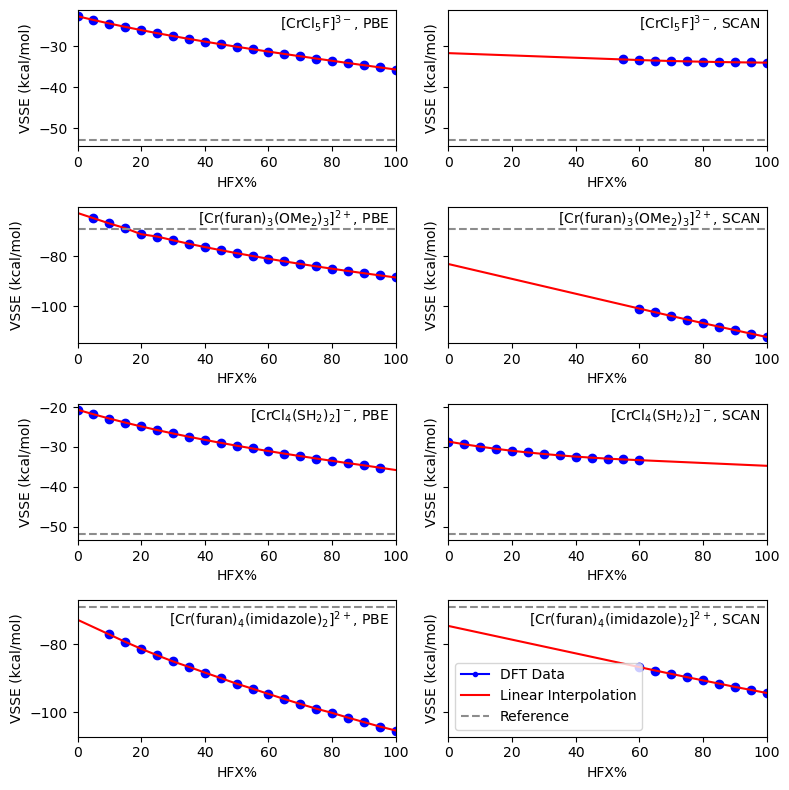

In [15]:
'''
cd_idx = [idx for idx in all_idx.index if 'cr/' in idx]
cd_idx

idxs = np.random.choice(cd_idx, 4, replace=False)
idxs
'''
idxs = ['cr/3/cr_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_fluoride-F-0-d1_4',
       'cr/2/cr_2_furan-O-0-0_furan-O-0-0_ome2-O-0-0_ome2-O-0-0_furan-O-0-0_ome2-O-0-0_5',
       'cr/3/cr_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_SH2-S-0-0_SH2-S-0-0_4',
       'cr/2/cr_2_furan-O-0-0_furan-O-0-0_furan-O-0-0_furan-O-0-0_imidazole-N-2-0_imidazole-N-2-0_5']

sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')
df = vss_452

fig, ax = plt.subplots(4, 2, figsize=(8, 8), sharex='col', sharey='row')
ax[0,0].set_xlim((0,100))
ax[0,1].set_xlim((0,100))
for idx, structure in enumerate(idxs):
    for jdx, functional in enumerate(['pbe', 'scan']):
        reference = df.loc[structure.split('/')[-1]]['dlpno-CCSD_T.vertsse']
        all_increments = np.arange(0, 101, 5)
        increments = []
        sses = []
        for i, increment in enumerate(all_increments):
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                sses.append(sse)
                increments.append(increment)
        ax[idx, jdx].plot(increments, sses, 'o', label='True Values', linewidth=3, color='#0000FF')
        ax[idx, jdx].set_xlabel('HFX%')
        ax[idx, jdx].set_ylabel('VSSE (kcal/mol)')
        if len(increments) < 2:
            print('Not enough converged values!')
            continue

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        ax[idx, jdx].plot(np.arange(0, 101, 1), line(np.arange(0, 101, 1)), label='Linear Interpolation', color='#FF0000')
        ax[idx, jdx].axhline(reference, linestyle='--', label='Reference', color='#8c8c8c')

ax[0,0].text(98, -22, r'[CrCl$_5$F]$^{3-}$, PBE', horizontalalignment='right', verticalalignment='top')
ax[1,0].text(98, -61, r'[Cr(furan)$_3$(OMe$_2$)$_3$]$^{2+}$, PBE', horizontalalignment='right', verticalalignment='top')
ax[2,0].text(98, -20, r'[CrCl$_4$(SH$_2$)$_2$]$^-$, PBE', horizontalalignment='right', verticalalignment='top')
ax[3,0].text(98, -70, r'[Cr(furan)$_4$(imidazole)$_2$]$^{2+}$, PBE', horizontalalignment='right', verticalalignment='top')

ax[0,1].text(98, -22, r'[CrCl$_5$F]$^{3-}$, SCAN', horizontalalignment='right', verticalalignment='top')
ax[1,1].text(98, -61, r'[Cr(furan)$_3$(OMe$_2$)$_3$]$^{2+}$, SCAN', horizontalalignment='right', verticalalignment='top')
ax[2,1].text(98, -20, r'[CrCl$_4$(SH$_2$)$_2$]$^-$, SCAN', horizontalalignment='right', verticalalignment='top')
ax[3,1].text(98, -70, r'[Cr(furan)$_4$(imidazole)$_2$]$^{2+}$, SCAN', horizontalalignment='right', verticalalignment='top')

ax[0,0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0,1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1,0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1,1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[2,0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[2,1].xaxis.set_tick_params(which='both', labelbottom=True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], ls='-', marker='o', ms=3, label='DFT Data', color='#0000FF'),
                Line2D([0], [0], ls='-', label='Linear Interpolation', color='#FF0000'),
                Line2D([0], [0], ls='--', label='Reference', color='#8c8c8c')]
ax[3,1].legend(custom_lines, ['DFT Data', 'Linear Interpolation', 'Reference'])

fig.tight_layout()

# Distributions of Optimal HFX Values, Slopes

In [16]:
#determine optimal HFX, slopes at intersections

csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

complexes = csd_sse_df.index
functionals = csd_sse_df.columns

def correct_hfx(structure, functional):
    '''
    structure is the name of the complex in the csd_76 dataframe.
    functional is the base functional of interest, either 'pbe' or 'scan'
    '''
    df = csd_76
    reference = df.loc[structure]['dlpno-CCSD_T.vertsse']

    sses = []
    all_increments = np.arange(0, 101, 5)
    sse_ref = csd_sse_df
    increments = []
    for increment in all_increments:
        sse = sse_ref.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return np.nan

    fit = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    sse_intersection = lambda hfx: (fit(hfx) - reference)**2
    res = minimize(sse_intersection, 25, method='Nelder-Mead')#, bounds=((0,100),))
    if res.success:
        min_error = res.fun
        result = res.x[0]
    else:
        print(idx, res)
    #try other initial guesses to see if we can improve
    for guess in [0, 50, 75, 100]:
        res = minimize(sse_intersection, guess, method='Nelder-Mead')#, bounds=((0,100),))
        if res.success:
            if res.fun < min_error -0.1 and res.x[0] >=0 and res.x[0] <= 100:
                result = res.x[0]
        else:
            print(idx, res)

    slope = (fit(result+0.1) - fit(result-0.1)) / (0.2)
    return result, slope, ((sses[0]-sses[-1])/(increments[0]-increments[-1]))

csd_hfx_df = pd.DataFrame(index=complexes, columns=['hfx_pbe', 'hfx_scan'])

for name in complexes:
    csd_hfx_df['hfx_pbe'][name] = correct_hfx(name, 'pbe')
    csd_hfx_df['hfx_scan'][name] = correct_hfx(name, 'scan')

#first entry is the optimal HFX. second is the slope at the linear interpolation intersection. third is overall slope.

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

complexes = vss_sse_df.index
functionals = vss_sse_df.columns

def correct_hfx(structure, functional):
    df = vss_452
    reference = df.loc[structure.split('/')[-1]]['dlpno-CCSD_T.vertsse']

    sses = []
    all_increments = np.arange(0, 101, 5)
    sse_ref = vss_sse_df
    increments = []
    for increment in all_increments:
        sse = sse_ref.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return np.nan

    fit = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    sse_intersection = lambda hfx: (fit(hfx) - reference)**2
    res = minimize(sse_intersection, 25, method='Nelder-Mead')#, bounds=((0,100),))
    if res.success:
        min_error = res.fun
        result = res.x[0]
    else:
        print(idx, res)
    #try other initial guesses to see if we can improve
    for guess in [0, 50, 75, 100]:
        res = minimize(sse_intersection, guess, method='Nelder-Mead')#, bounds=((0,100),))
        if res.success:
            if res.fun < min_error-0.1 and res.x[0] >=0 and res.x[0] <= 100:
                result = res.x[0]
        else:
            print(idx, res)

    slope = (fit(result+0.1) - fit(result-0.1)) / (0.2)
    return result, slope, ((sses[0]-sses[-1])/(increments[0]-increments[-1]))

vss_hfx_df = pd.DataFrame(index=complexes, columns=['hfx_pbe', 'hfx_scan'])

for name in complexes:
    vss_hfx_df['hfx_pbe'][name] = correct_hfx(name, 'pbe')
    vss_hfx_df['hfx_scan'][name] = correct_hfx(name, 'scan')

In [17]:
#confirm the targets are the same

for idx, row in csd_hfx_df.iterrows():
    old_row = csd_targets.loc[idx]
    if not np.any(np.isnan(row['hfx_pbe'])):
        if not np.isclose(row['hfx_pbe'][0], old_row['hfx_pbe']):
            print(idx)
    if not np.any(np.isnan(row['hfx_scan'])):
        if not np.isclose(row['hfx_scan'][0], old_row['hfx_scan']):
            print(idx)

for idx, row in vss_hfx_df.iterrows():
    old_row = vss_targets.loc[idx]
    if not np.any(np.isnan(row['hfx_pbe'])):
        if not np.isclose(row['hfx_pbe'][0], old_row['hfx_pbe']):
            print(idx)
    if not np.any(np.isnan(row['hfx_scan'])):
        if not np.isclose(row['hfx_scan'][0], old_row['hfx_scan']):
            print(idx)

CSD PBE:
Number of points: 69
Mean: 32.93463444364244
Median: 31.167984008789062
25th Percentile: 26.92962646484375
75th Percentile: 35.31990051269531
CSD SCAN:
Number of points: 67
Mean: 32.48356036285856
Median: 33.473052978515625
25th Percentile: 24.726028442382812
75th Percentile: 38.1573486328125


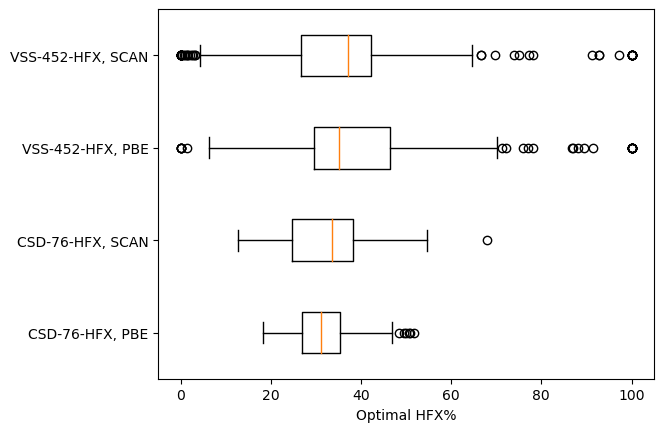

In [18]:
#boxplot of optimal HFX values

csd_pbe = []
csd_scan = []

for idx, row in csd_hfx_df.iterrows():
    pbe = row['hfx_pbe']
    scan = row['hfx_scan']
    if not np.all(np.isnan(pbe)):
        if pbe[0] > 100:
            csd_pbe.append(100)
        elif pbe[0] < 0:
            csd_pbe.append(0)
        else:
            csd_pbe.append(pbe[0])
    if not np.all(np.isnan(scan)):
        if scan[0] > 100:
            csd_scan.append(100)
        elif scan[0] < 0:
            csd_scan.append(0)
        else:
            csd_scan.append(scan[0])

vss_pbe = []
vss_scan = []

for idx, row in vss_hfx_df.iterrows():
    pbe = row['hfx_pbe']
    scan = row['hfx_scan']
    if not np.all(np.isnan(pbe)):
        if pbe[0] > 100:
            vss_pbe.append(100)
        elif pbe[0] < 0:
            vss_pbe.append(0)
        else:
            vss_pbe.append(pbe[0])
    if not np.all(np.isnan(scan)):
        if scan[0] > 100:
            vss_scan.append(100)
        elif scan[0] < 0:
            vss_scan.append(0)
        else:
            vss_scan.append(scan[0])

all_hfx = [csd_pbe, csd_scan, vss_pbe, vss_scan]
labels = ['CSD-76-HFX, PBE', 'CSD-76-HFX, SCAN', 'VSS-452-HFX, PBE', 'VSS-452-HFX, SCAN']

fig, ax = plt.subplots()
ax.boxplot(all_hfx, vert=False)
ax.set_yticklabels(labels)
ax.set_xlabel('Optimal HFX%')

csd_pbe = np.array(csd_pbe)
print('CSD PBE:')
print(f'Number of points: {len(csd_pbe)}')
print(f'Mean: {csd_pbe.mean()}')
print(f'Median: {np.median(csd_pbe)}')
print(f'25th Percentile: {np.percentile(csd_pbe, 25)}')
print(f'75th Percentile: {np.percentile(csd_pbe, 75)}')

csd_scan = np.array(csd_scan)
print('CSD SCAN:')
print(f'Number of points: {len(csd_scan)}')
print(f'Mean: {csd_scan.mean()}')
print(f'Median: {np.median(csd_scan)}')
print(f'25th Percentile: {np.percentile(csd_scan, 25)}')
print(f'75th Percentile: {np.percentile(csd_scan, 75)}')

CSD PBE:
Number of points: 69
Mean: -0.7701857692219267
Median: -0.7649210521267236
25th Percentile: -0.8310966285589028
75th Percentile: -0.6719700689379238
CSD SCAN:
Number of points: 67
Mean: -0.7564669512603759
Median: -0.7510192219079537
25th Percentile: -0.8177394120932968
75th Percentile: -0.6778557494605408


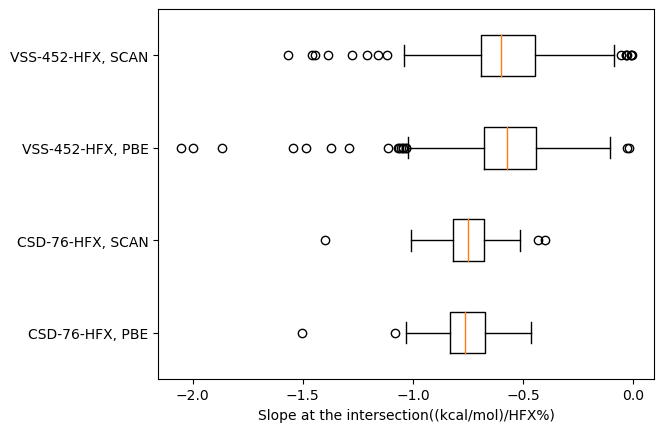

In [19]:
csd_pbe_slopes = []
csd_scan_slopes = []

for idx, row in csd_hfx_df.iterrows():
    pbe = row['hfx_pbe']
    scan = row['hfx_scan']
    if not np.all(np.isnan(pbe)):
        csd_pbe_slopes.append(pbe[1])
    if not np.all(np.isnan(scan)):
        csd_scan_slopes.append(scan[1])

vss_pbe_slopes = []
vss_scan_slopes = []

for idx, row in vss_hfx_df.iterrows():
    pbe = row['hfx_pbe']
    scan = row['hfx_scan']
    if not np.all(np.isnan(pbe)):
        vss_pbe_slopes.append(pbe[1])
    if not np.all(np.isnan(scan)):
        vss_scan_slopes.append(scan[1])

all_slopes = [csd_pbe_slopes, csd_scan_slopes, vss_pbe_slopes, vss_scan_slopes]
labels = ['CSD-76-HFX, PBE', 'CSD-76-HFX, SCAN', 'VSS-452-HFX, PBE', 'VSS-452-HFX, SCAN']

fig, ax = plt.subplots()
ax.boxplot(all_slopes, vert=False)
ax.set_yticklabels(labels)
ax.set_xlabel('Slope at the intersection((kcal/mol)/HFX%)')
#ax.set_xlabel('Overall slope ((kcal/mol)/HFX%)')

pbe_slopes = np.array(csd_pbe_slopes)
print('CSD PBE:')
print(f'Number of points: {len(pbe_slopes)}')
print(f'Mean: {pbe_slopes.mean()}')
print(f'Median: {np.median(pbe_slopes)}')
print(f'25th Percentile: {np.percentile(pbe_slopes, 25)}')
print(f'75th Percentile: {np.percentile(pbe_slopes, 75)}')

scan_slopes = np.array(csd_scan_slopes)
print('CSD SCAN:')
print(f'Number of points: {len(scan_slopes)}')
print(f'Mean: {scan_slopes.mean()}')
print(f'Median: {np.median(scan_slopes)}')
print(f'25th Percentile: {np.percentile(scan_slopes, 25)}')
print(f'75th Percentile: {np.percentile(scan_slopes, 75)}')

# Best Single HFX

In [20]:
vss_df = pd.read_csv('../data/VSS-452.csv')
csd_df = pd.read_csv('../data/CSD-76.csv')
to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in row['name']:
        to_remove.append(idx)
csd_df = csd_df.drop(to_remove)

functionals = ['pbe', 'scan']

single_hfx_pbe_csd = np.nan
single_hfx_scan_csd = np.nan
single_hfx_pbe_vss = np.nan
single_hfx_scan_vss = np.nan

for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            datasetname = 'CSD76'
        else:
            datasetname = 'VSS452'
        print(f'Functional {base_functional} dataset {datasetname}:')
        if idx == 0:
            if base_functional == 'pbe':
                df = csd_pbe_sse
            else:
                df = csd_scan_sse
            reference_df = csd_df
        else:
            if base_functional == 'pbe':
                df = vss_pbe_sse
            else:
                df = vss_scan_sse
            reference_df = vss_df
            
        def objective(optimal_hfx, df, reference_df):
            errors = []
            for _, row in df.iterrows():
                hfx_vals = []
                vsses = []
                optimal_vsse = reference_df.loc[reference_df['name'] == row.name.split('/')[-1]]['dlpno-CCSD_T.vertsse'].item()
                for hfx in row.index:
                    if not np.isnan(row[hfx]):
                        hfx_vals.append(hfx)
                        vsses.append(row[hfx])
                if len(hfx_vals) < 5:
                    continue
                fit = interp1d(hfx_vals, vsses, kind='linear', fill_value='extrapolate')
                errors.append(np.abs(fit(optimal_hfx) - optimal_vsse))
            return np.mean(errors)

        fun = lambda hfx: objective(hfx, df, reference_df)
        res = minimize(fun, 40, method='Nelder-Mead')
        print(res)
        if idx == 0:
            if base_functional == 'pbe':
                single_hfx_pbe_csd = res.fun
            else:
                single_hfx_scan_csd = res.fun
        else:
            if base_functional == 'pbe':
                single_hfx_pbe_vss = res.fun
            else:
                single_hfx_scan_vss = res.fun

Functional pbe dataset CSD76:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.006685965037144
             x: [ 3.127e+01]
           nit: 19
          nfev: 38
 final_simplex: (array([[ 3.127e+01],
                       [ 3.127e+01]]), array([ 5.007e+00,  5.007e+00]))
Functional pbe dataset VSS452:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.929096577429319
             x: [ 3.512e+01]
           nit: 18
          nfev: 36
 final_simplex: (array([[ 3.512e+01],
                       [ 3.512e+01]]), array([ 6.929e+00,  6.929e+00]))
Functional scan dataset CSD76:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.679388418962995
             x: [ 3.307e+01]
           nit: 23
          nfev: 46
 final_simplex: (array([[ 3.307e+01],
                       [ 3.307e+01]]), array([ 5.679e+00,  5.679e+00

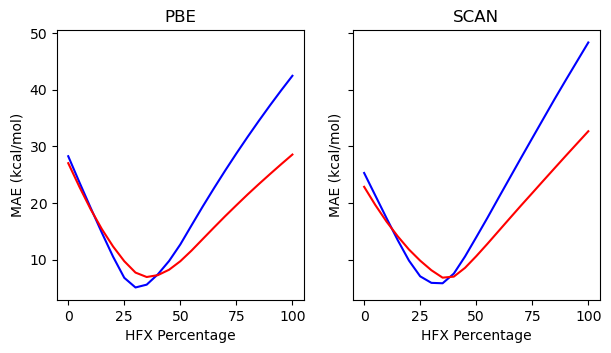

In [21]:
vss_df = pd.read_csv('../data/VSS-452.csv')
csd_df = pd.read_csv('../data/CSD-76.csv')
to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in row['name']:
        to_remove.append(idx)
csd_df = csd_df.drop(to_remove)

functionals = ['pbe', 'scan']

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            if base_functional == 'pbe':
                df = csd_pbe_sse
            else:
                df = csd_scan_sse
            reference_df = csd_df
        else:
            if base_functional == 'pbe':
                df = vss_pbe_sse
            else:
                df = vss_scan_sse
            reference_df = vss_df
            
        def objective(optimal_hfx, df, reference_df):
            errors = []
            for _, row in df.iterrows():
                hfx_vals = []
                vsses = []
                optimal_vsse = reference_df.loc[reference_df['name'] == row.name.split('/')[-1]]['dlpno-CCSD_T.vertsse'].item()
                for hfx in row.index:
                    if not np.isnan(row[hfx]):
                        hfx_vals.append(hfx)
                        vsses.append(row[hfx])
                if len(hfx_vals) < 5:
                    continue
                fit = interp1d(hfx_vals, vsses, kind='linear', fill_value='extrapolate')
                errors.append(np.abs(fit(optimal_hfx) - optimal_vsse))
            return np.mean(errors)

        if idx == 0:
            color='#0000FF'
        else:
            color='#FF0000'
        if base_functional == 'pbe':
            ax[0].plot(np.arange(0, 101, 5), [objective(x, df, reference_df) for x in np.arange(0, 101, 5)], color=color)
        else:
            ax[1].plot(np.arange(0, 101, 5), [objective(x, df, reference_df) for x in np.arange(0, 101, 5)], color=color)
            
        ax[0].set_xlabel('HFX Percentage')
        ax[0].set_ylabel('MAE (kcal/mol)')
        ax[1].set_xlabel('HFX Percentage')
        ax[1].set_ylabel('MAE (kcal/mol)')
        ax[0].set_title('PBE')
        ax[1].set_title('SCAN')
        #fig.tight_layout()

# System-Specific Performance

In [22]:
vss_df = pd.read_csv('../data/VSS-452.csv').set_index('name')
csd_df = pd.read_csv('../data/CSD-76.csv').set_index('name')
to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in idx:
        to_remove.append(idx)
csd_df = csd_df.drop(to_remove)

functionals = ['pbe', 'scan']

specific_hfx_pbe_csd = np.nan
specific_hfx_scan_csd = np.nan
specific_hfx_pbe_vss = np.nan
specific_hfx_scan_vss = np.nan

for base_functional in functionals:
    for idx, target_df in enumerate([csd_targets, vss_targets]):
        if idx == 0:
            if base_functional == 'pbe':
                df = csd_pbe_sse
            else:
                df = csd_scan_sse
            reference_df = csd_df
        else:
            if base_functional == 'pbe':
                df = vss_pbe_sse
            else:
                df = vss_scan_sse
            reference_df = vss_df
            
        def objective(df, reference_df, target_df):
            errors = []
            total = 0
            num_not_reproduced = 0
            for _, row in df.iterrows():
                hfx_vals = []
                vsses = []
                optimal_vsse = reference_df.loc[row.name.split('/')[-1]]['dlpno-CCSD_T.vertsse'].item()
                for hfx in row.index:
                    if not np.isnan(row[hfx]):
                        hfx_vals.append(hfx)
                        vsses.append(row[hfx])
                if len(hfx_vals) < 5:
                    continue
                total += 1
                fit = interp1d(hfx_vals, vsses, kind='linear', fill_value='extrapolate')

                optimal_hfx = target_df.loc[row.name]['hfx_' + base_functional].item()
                if optimal_hfx > 100 or optimal_hfx < 0:
                    #num_not_reproduced += 1
                    pass
                if optimal_hfx > 100:
                    optimal_hfx = 100
                    #if np.abs(fit(optimal_hfx) - optimal_vsse) < 1:
                        #print(row.name, optimal_hfx)
                elif optimal_hfx < 0:
                    optimal_hfx = 0
                    #if np.abs(fit(optimal_hfx) - optimal_vsse) < 1:
                        #print(row.name, optimal_hfx)
                errors.append(np.abs(fit(optimal_hfx) - optimal_vsse))
                if not np.isclose(errors[-1], 0, atol=1):
                    num_not_reproduced += 1
                    #print(row.name, errors[-1], optimal_hfx)
                    #if optimal_hfx > hfx_vals[-1] or optimal_hfx < hfx_vals[0]:
                        #print(row.name, optimal_hfx, errors[-1])
            return np.mean(errors), num_not_reproduced, total-num_not_reproduced, (total-num_not_reproduced)/total

        print(base_functional, idx, objective(df, reference_df, target_df))
        
        if idx == 0:
            if base_functional == 'pbe':
                specific_hfx_pbe_csd = objective(df, reference_df, target_df)[0]
            else:
                specific_hfx_scan_csd = objective(df, reference_df, target_df)[0]
        else:
            if base_functional == 'pbe':
                specific_hfx_pbe_vss = objective(df, reference_df, target_df)[0]
            else:
                specific_hfx_scan_vss = objective(df, reference_df, target_df)[0]

#read as functional - dataset (0=CSD-76, 1=VSS-452) - minimum error (kcal/mol) - #structures with reference reproduced - %structures with reference reproduced

pbe 0 (6.963665331273899e-06, 0, 69, 1.0)
pbe 1 (0.6169181057421301, 15, 390, 0.9629629629629629)
scan 0 (7.665537770411103e-06, 0, 67, 1.0)
scan 1 (0.6802853729358146, 25, 366, 0.9360613810741688)
